In [2]:
!pip install sastrawi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.6 MB/s eta 0:00:00


In [8]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize
import nltk
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import tensorflow as tf
factory = StemmerFactory()
stemmer = factory.create_stemmer()
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np


In [4]:
df = pd.read_csv('pungli.csv')
df['review'].dropna(inplace=True)
df['sentiment'].dropna(inplace=True)
df.head()

,review,sentiment
0,View nya bagus cuma saya ada beberapa lapak ga...,1.0
1,"Cukup 1 kali aja ke sini, kapok ngga lagi ke s...",2.0
2,"sebenarnya tempatnya bagus, apalgi buat refres...",2.0
3,"gasuka banget, banyak pungli nya.\nmasuk ke gn...",2.0
4,"Udaranya sejuk, pemandanganya nyejukin mata bg...",1.0


In [5]:
#hapus karakter selain huruf dan angka
#hapus new line char dan double space
def secondClean(text):
    cleaned = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    cleaned = cleaned.replace('\n', ' ')
    cleaned = cleaned.replace ('  ', ' ')
    return cleaned
def lowercase(text):
    lowered = text.lower()
    return lowered
def stopwording(text):
    with open('combined2.txt', 'r') as f:
        stop_words = f.read().splitlines()
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    return filtered_sentence
def lemma(text):
    return [stemmer.stem(word) for word in text]
# Fungsi pre-processing tambahan untuk mengatasi slang words
#def freqDist(text):
    #freq_dist = nltk.FreqDist(text)
    #return freq_dist

In [10]:
nltk.download('punkt_tab')
df['cleaned'] = df['review'].apply(secondClean)
df['cleaned'] = df['cleaned'].apply(lowercase)
df['cleaned'] = df['cleaned'].apply(stopwording)
df['cleaned'] = df['cleaned'].apply(lemma)
df['cleaned'].head()

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


,cleaned
0,"[bagus, urus]"
1,"[kapok, pungli, 10000]"
2,"[bagus, refresing, pungli, pungli]"
3,"[gasuka, pungli, 20rb, bayar, 10rb, motor, 5rb]"
4,"[sejuk, nyejukin, bagus]"


In [11]:
df = df.dropna(subset=['sentiment']).replace([np.inf, -np.inf], np.nan).dropna(subset=['sentiment'])


In [12]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer

# Siapkan data untuk dimasukkan ke model (features) dan data yang akan diprediksi (labels)
X = df.cleaned
y = df.sentiment
# Split data menjadi 70% untuk latih dan 30% untuk uji
max_words = 100
max_len = 20
tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=70)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_sequence, maxlen=max_len)
X_test_pad = pad_sequences(X_test_sequence, maxlen=max_len)



In [13]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_words, 128, input_length=max_len),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Dense(256),
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.LSTM(128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss= 'sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [14]:
model.fit(X_train_pad, y_train, epochs=50, batch_size=128, validation_data=(X_test_pad, y_test))
# Model evaluation
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Loss: {loss}, Accuracy: {accuracy}')

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 354ms/step - accuracy: 0.5572 - loss: 0.9327 - val_accuracy: 0.8197 - val_loss: 0.5542
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step - accuracy: 0.8885 - loss: 0.3711 - val_accuracy: 0.8435 - val_loss: 0.4780
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step - accuracy: 0.8844 - loss: 0.3574 - val_accuracy: 0.8401 - val_loss: 0.4904
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step - accuracy: 0.8984 - loss: 0.3853 - val_accuracy: 0.8912 - val_loss: 0.3930
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.9057 - loss: 0.3184 - val_accuracy: 0.8605 - val_loss: 0.4208
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 188ms/step - accuracy: 0.9189 - loss: 0.2811 - val_accuracy: 0.8639 - val_loss: 0.4265
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 0.8985 - loss: 0.2989 - val_accuracy: 0.8503 - val_loss: 0.4890
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 359ms/step - accuracy: 0.9139 - loss: 0.2754 - val_accuracy: 0.8469 - val_loss:

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 151ms/step


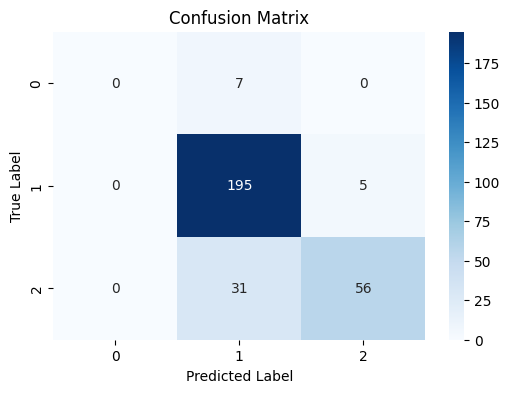

Classification Report:

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         7
         1.0       0.84      0.97      0.90       200
         2.0       0.92      0.64      0.76        87

    accuracy                           0.85       294
   macro avg       0.58      0.54      0.55       294
weighted avg       0.84      0.85      0.84       294



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

# Confusion Matrix
y_pred = model.predict(X_test_pad)
y_pred_classes = np.argmax(y_pred, axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_test, y_pred_classes))


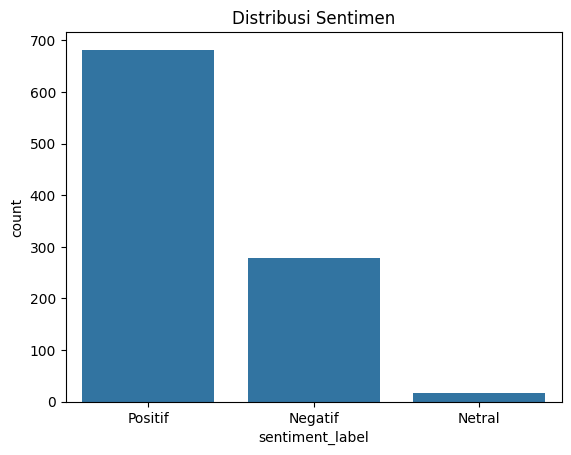

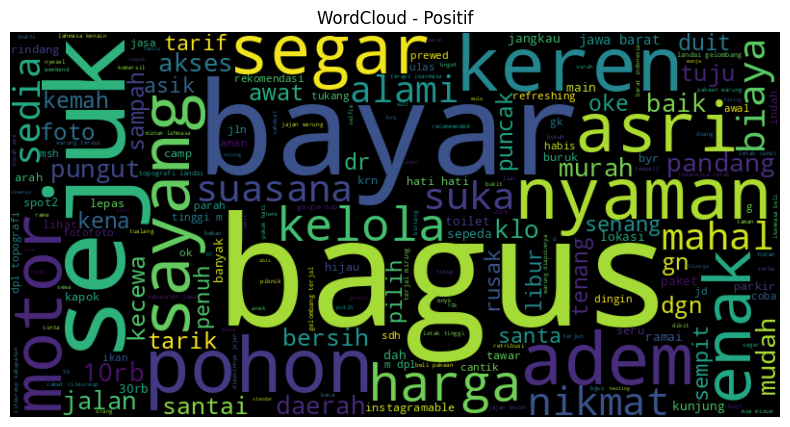

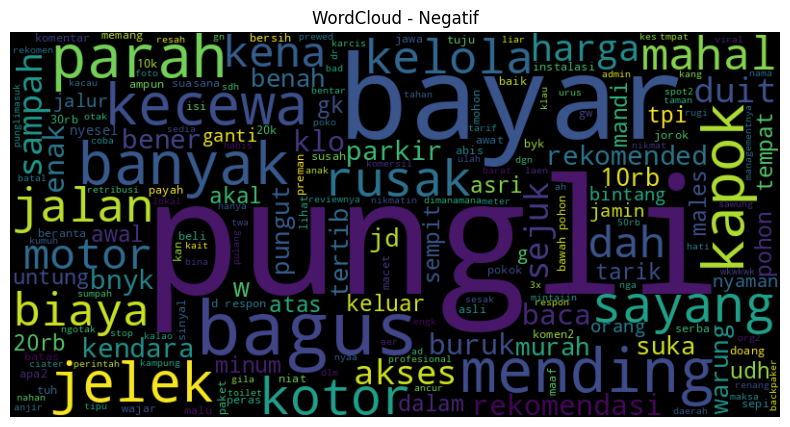

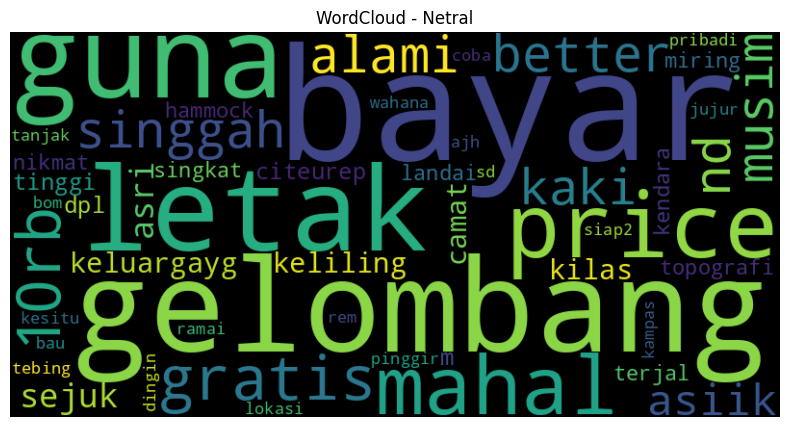

In [17]:
from collections import Counter
from wordcloud import WordCloud

sentiment_label_map = {0: 'Netral', 1: 'Positif', 2: 'Negatif'}
df['sentiment_label'] = df['sentiment'].map(sentiment_label_map)

# Distribusi Sentimen
sns.countplot(x='sentiment_label', data=df)
plt.title("Distribusi Sentimen")
plt.show()

# WordCloud per Sentimen
for label in df['sentiment_label'].unique():
    words = df[df['sentiment_label'] == label]['cleaned'].apply(lambda x: ' '.join(x))
    combined_text = ' '.join(words)
    wordcloud = WordCloud(width=800, height=400).generate(combined_text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud - {label}')
    plt.show()


In [18]:
sample_data = 'tempatnya agak kurang, banyak pungli dimana mana'
sample_data = secondClean(sample_data)
sample_data = lowercase(sample_data)
sample_data = stopwording(sample_data)
sample_data = lemma(sample_data)
sample_data_sequence = tokenizer.texts_to_sequences([sample_data])
sample_data_pad = pad_sequences(sample_data_sequence, maxlen=max_len)
prediction = model.predict(sample_data_pad)
predicted_class = np.argmax(prediction)
print(sample_data_sequence)
print(f'Predicted Sentiment: {predicted_class}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
[[1]]
Predicted Sentiment: 2


In [ ]:
if __name__ == '__main__':
    # DO NOT CHANGE THIS CODE
    model = model
    model.save("modaljalan4.h5")

C:\Users\faiq\PycharmProjects\ModalJalan\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Convert the model.
from tensorflow import lite
converter = lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter=True
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS]
tfmodel = converter.convert()

# Save the model.
with open('model3.tflite', 'wb') as f:
  f.write(tfmodel)

In [ ]:
import json

metadata = {
    "name": "my_model",
    "version": "1.0",
    "description": "Model for sentiment analysis",
    "architecture": [
        {"name": "Embedding", "units": 128, "input_length": 100},
        {"name": "Dense", "units": 128},
        {"name": "Dense", "units": 256},
        {"name": "SpatialDropout1D", "rate": 0.2},
        {"name": "LSTM", "units": 128, "dropout": 0.2, "recurrent_dropout": 0.2},
        {"name": "Dropout", "rate": 0.5},
        {"name": "Dense", "units": 3, "activation": "softmax"}
    ],
    "weights": "...",
    "configuration": {
        "learning_rate": 0.01,
        "optimizer": "Adam"
    },
    "data": "...",
    "creation_date": "2023-12-22",
    "creator": "Bard"
}

with open('model_metadata.json', 'w') as f:
    json.dump(metadata, f)
